In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from ydata_profiling import ProfileReport

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [3]:
# Define presets for data visualization
def presets():
    plt.rc('figure', autolayout = True)

    plt.rc('axes', 
        labelsize = 'large',
        labelweight = 'bold',
        titlesize = 14,
        titleweight = 'bold',
        titlepad = 10       
    )

    %config InlineBackend.figure_format = 'retina'
    pd.options.display.max_rows = 10
    sns.set_style('darkgrid')
    # Set preset for darkmode for matplotlib and seaborn visualizations
    # plt.style.use('dark_background')

    warnings.filterwarnings(action = 'ignore', category = UserWarning)
    return 

presets()



### Data Loading and Preprocessing
---

In [4]:
# Load the data
url = "path_to_your_data.csv"  # Replace with the actual path to your CSV file
# data = pd.read_csv(url)
data = pd.read_csv("data.csv")
df = data.copy()

In [5]:
df.shape

(48895, 16)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [7]:
# Check for missing values and show the number of missing values by column
def check_missing_value():
    # show number of missing values as a dataframe by column
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_values = missing_values.sort_values(ascending=False)
    missing_values = missing_values.reset_index()
    missing_values.columns = ["Feature", "Missing Values"]
    return missing_values


check_missing_value()

,Feature,Missing Values
0,reviews_per_month,10052
1,last_review,10052
2,host_name,21
3,name,16


In [8]:
# Check for duplicates and show the count of duplicates
def check_duplicates():
    # Count the number of duplicate rows
    duplicate_count = df.duplicated().sum()

    # Create a DataFrame to show the count of duplicates
    duplicates_df = pd.DataFrame(
        {"Feature": ["Duplicates"], "Count": [duplicate_count]}
    )

    return duplicates_df


# Call the function to check for duplicates
check_duplicates()

,Feature,Count
0,Duplicates,0


In [9]:
# Handle missing values
df = df.assign(reviews_per_month=df["reviews_per_month"].fillna(0))
df = df.dropna(subset=["last_review"])

df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,36425863,Lovely Privet Bedroom with Privet Restroom,83554966,Rusaa,Manhattan,Upper East Side,40.78099,-73.95366,Private room,129,1,1,2019-07-07,1.00,1,147
48790,36427429,No.2 with queen size bed,257683179,H Ai,Queens,Flushing,40.75104,-73.81459,Private room,45,1,1,2019-07-07,1.00,6,339
48799,36438336,Seas The Moment,211644523,Ben,Staten Island,Great Kills,40.54179,-74.14275,Private room,235,1,1,2019-07-07,1.00,1,87
48805,36442252,1B-1B apartment near by Metro,273841667,Blaine,Bronx,Mott Haven,40.80787,-73.92400,Entire home/apt,100,1,2,2019-07-07,2.00,1,40


In [10]:
# Convert data types
df["last_review"] = pd.to_datetime(df["last_review"])

### Step 2: Exploratory df Analysis (EDA)
---

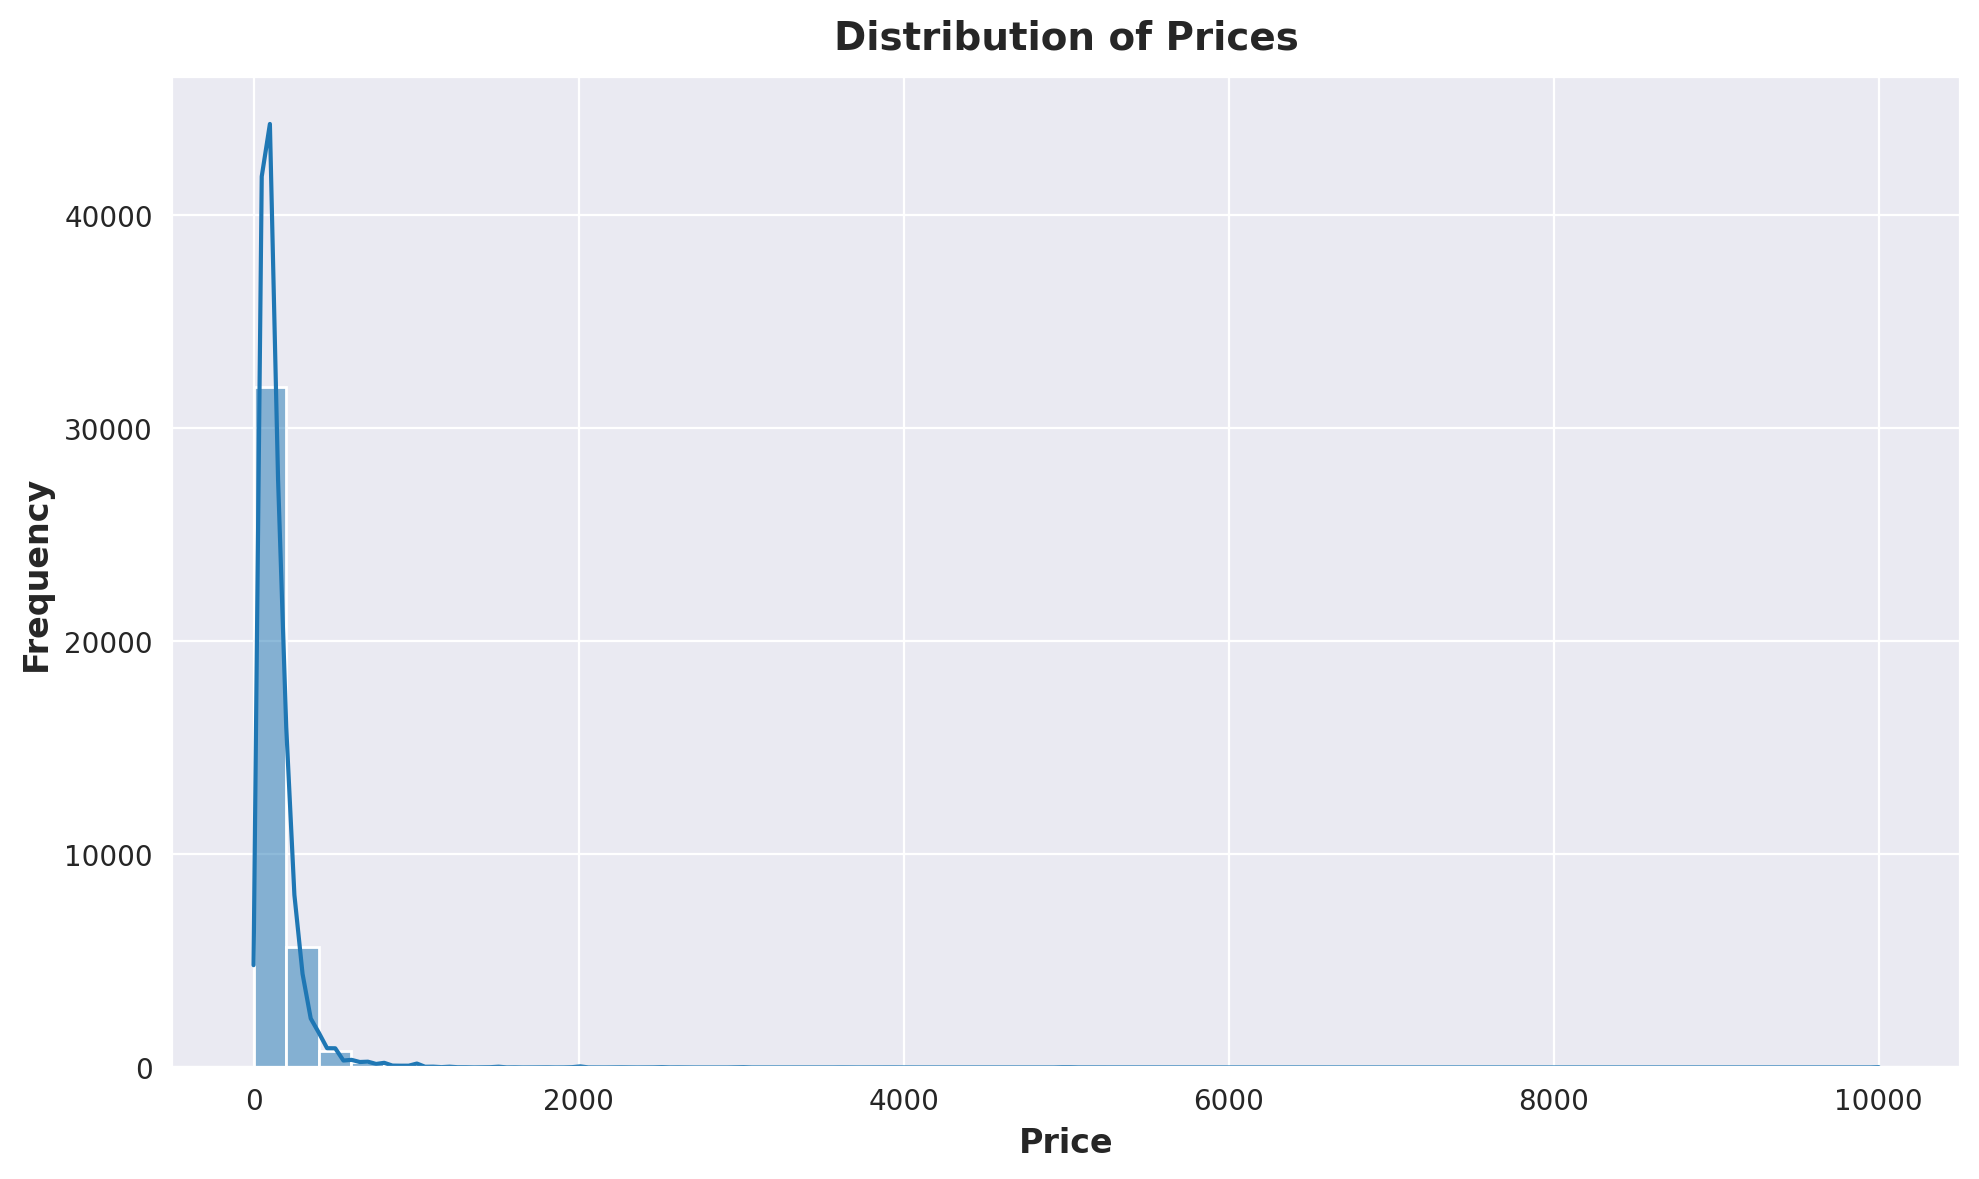

In [11]:
# Visualize the distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution of Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

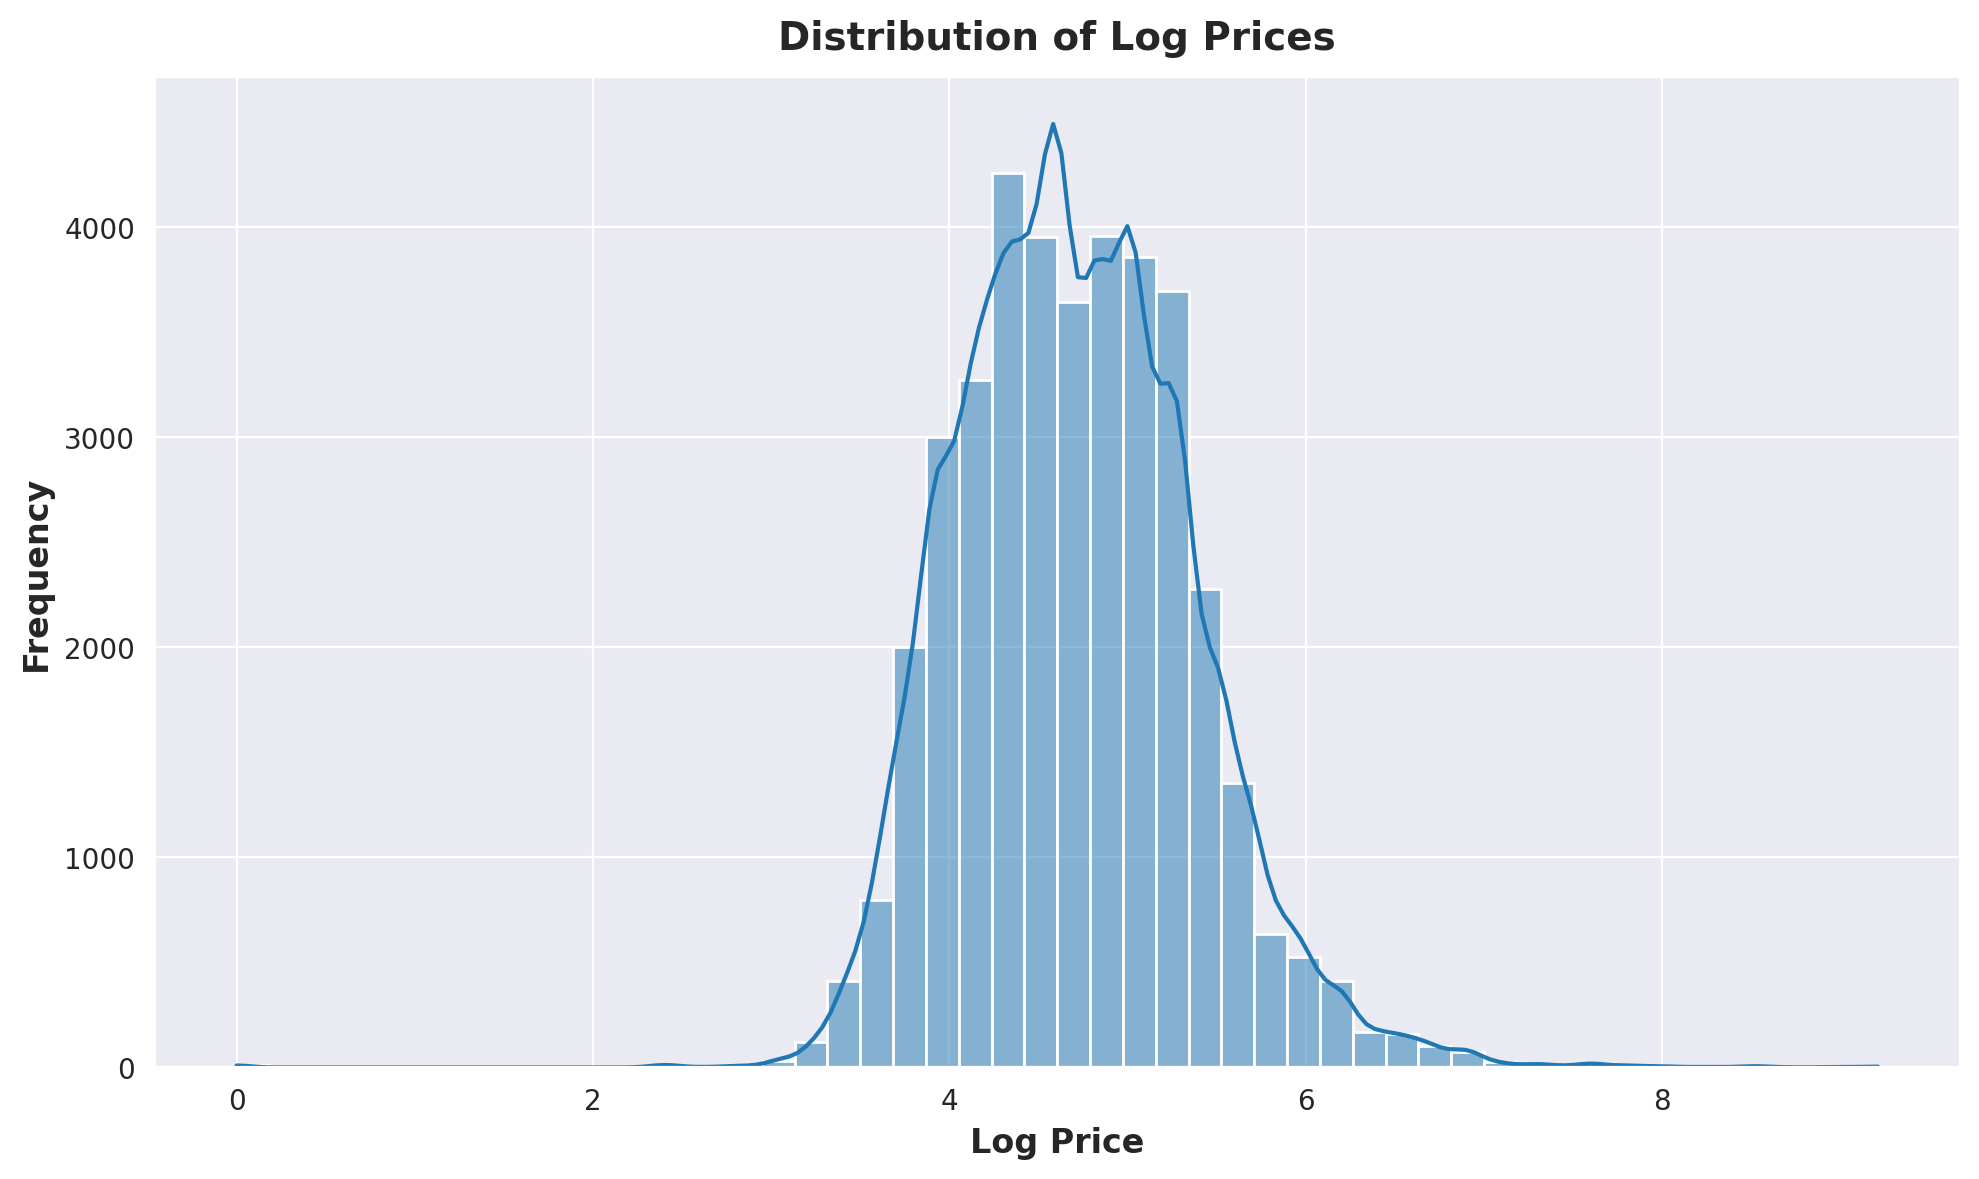

In [38]:
# Transform Price to Log Price
df["log_price"] = np.log1p(df["price"])

# Visualize the distribution of log prices
plt.figure(figsize=(10, 6))
sns.histplot(df["log_price"], bins=50, kde=True)
plt.title("Distribution of Log Prices")
plt.xlabel("Log Price")
plt.ylabel("Frequency")
plt.show()


<Figure size 3000x2000 with 0 Axes>

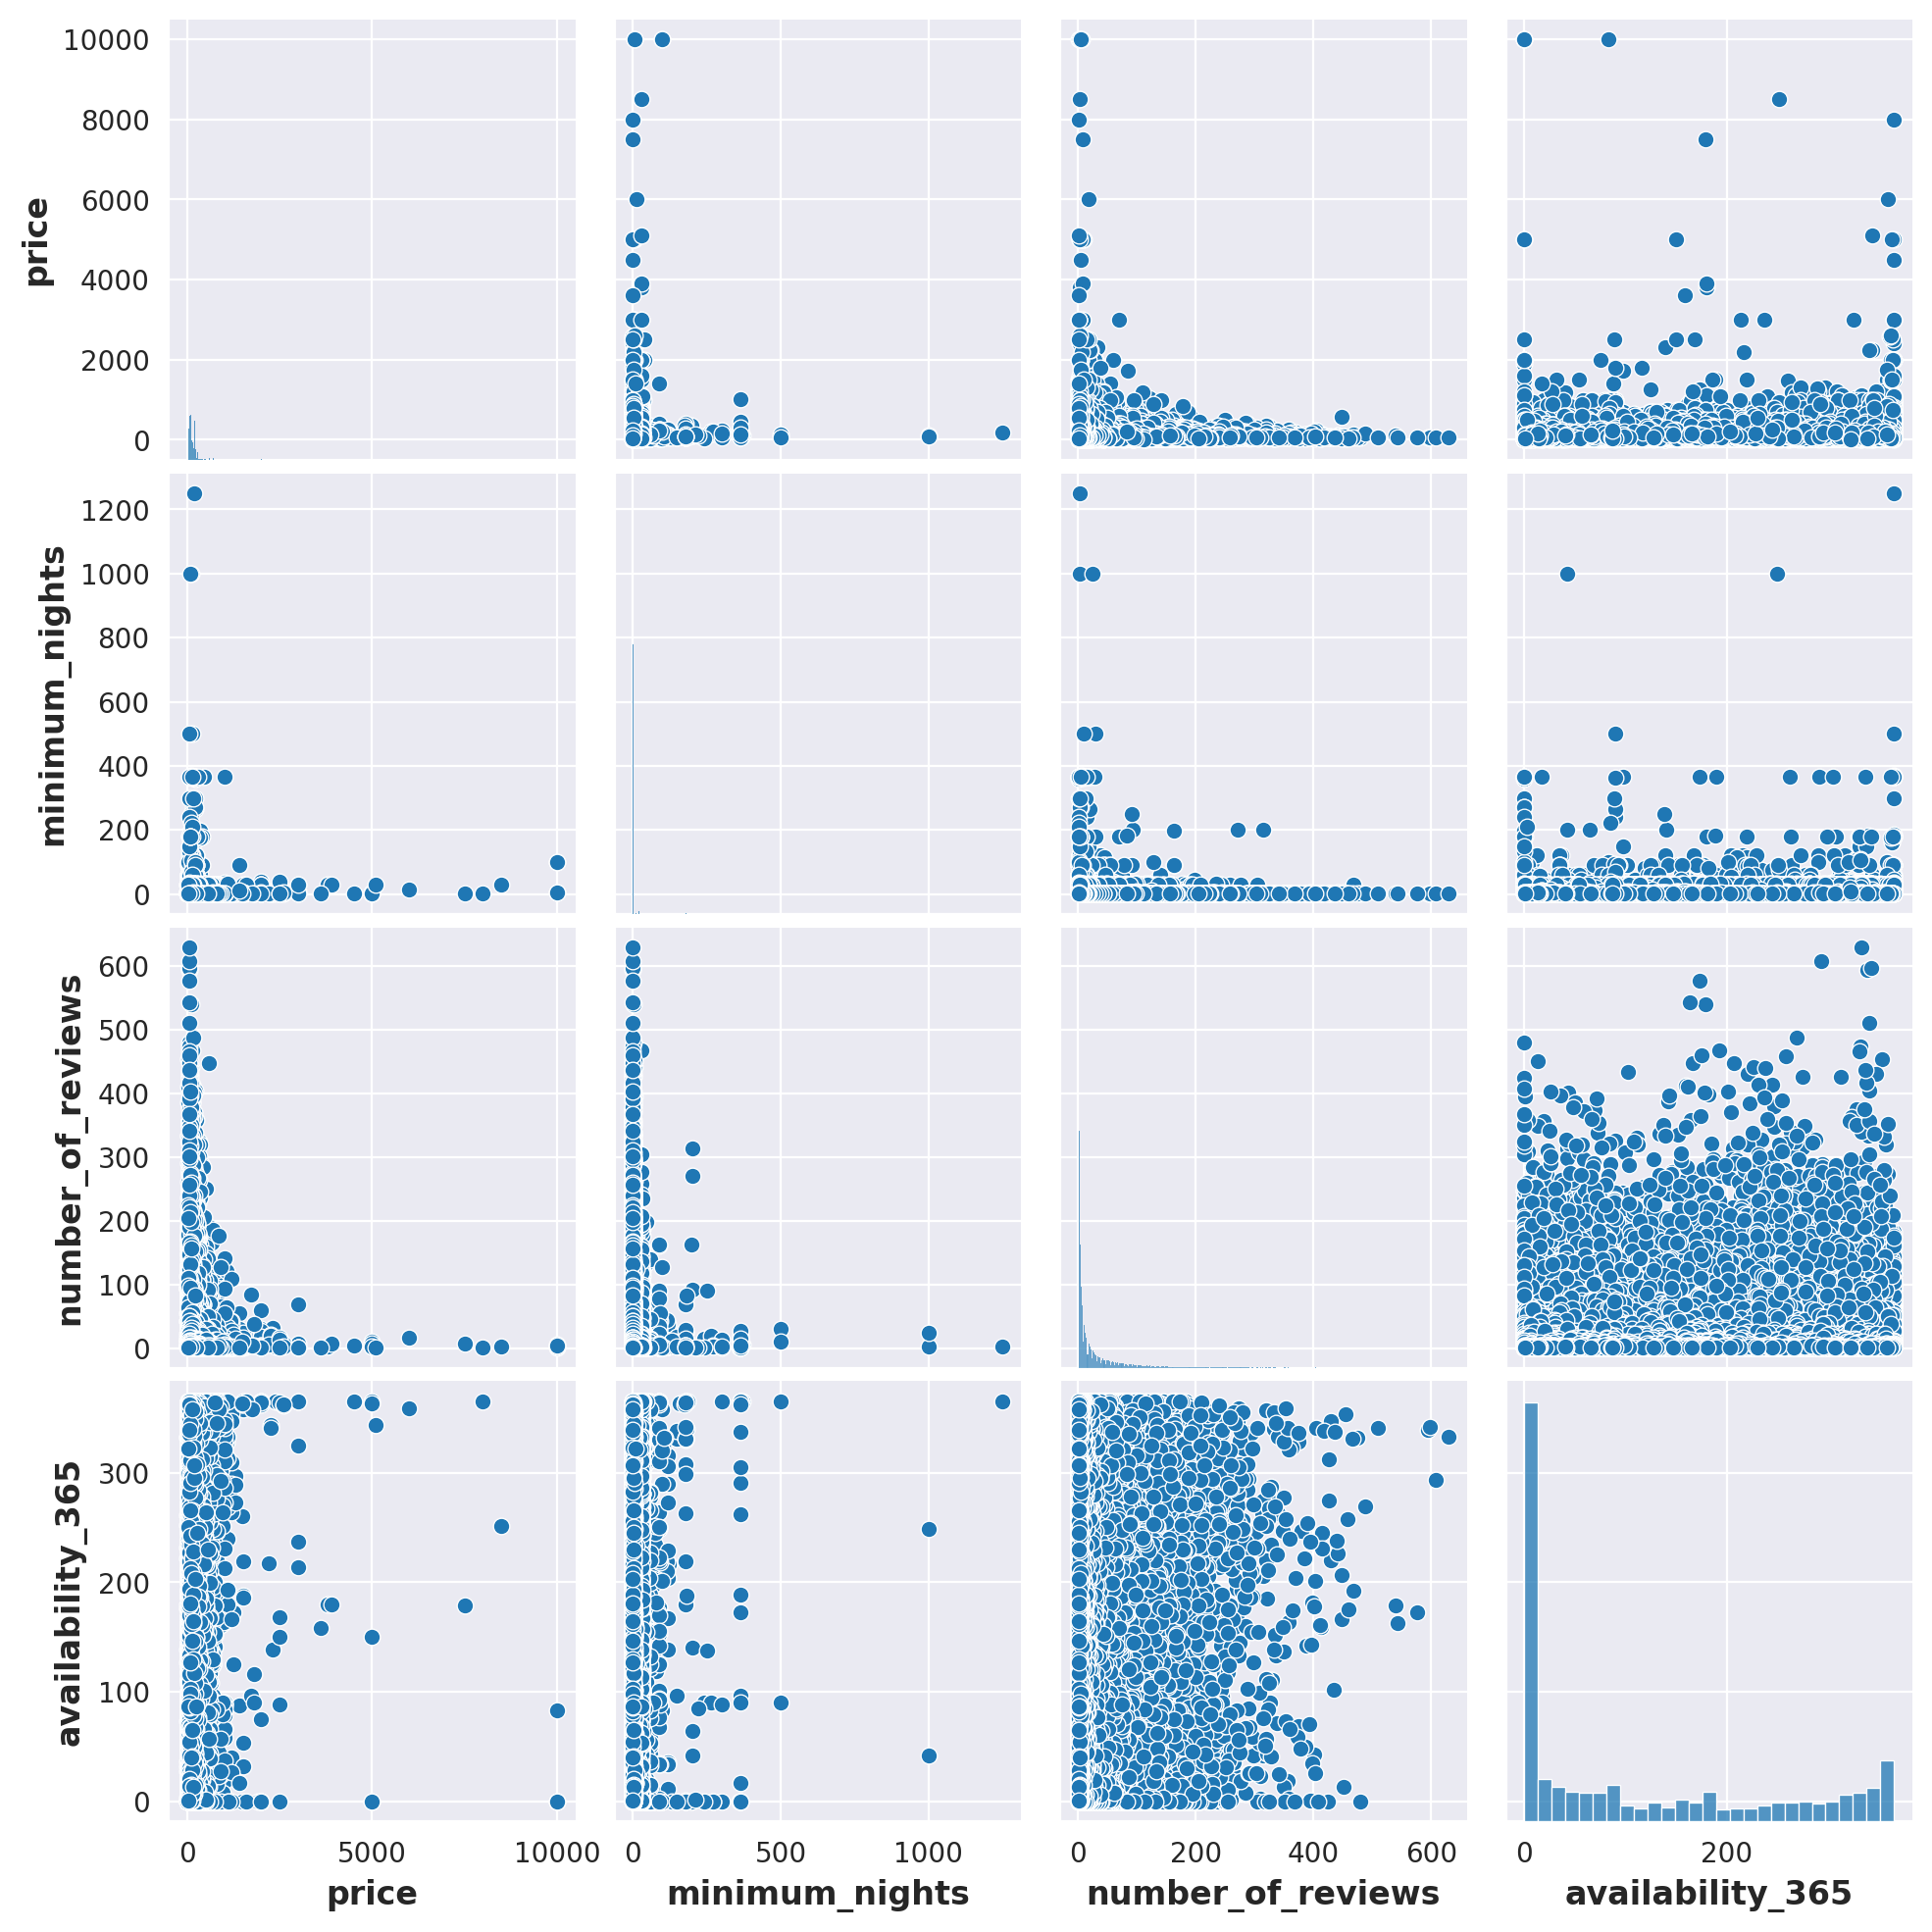

In [41]:
# Explore the relationship between price and other features
plt.figure(figsize=(30, 20))
sns.pairplot(
    df[
        [
            "price",
            "neighbourhood_group",
            "room_type",
            "minimum_nights",
            "number_of_reviews",
            "availability_365",
        ]
    ]
)
plt.show()

In [42]:
# Summarize key statistics
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,log_price
count,3.884300e+04,3.884300e+04,38843.000000,38843.000000,38843.000000,38843.000000,38843.000000,38843,38843.000000,38843.000000,38843.000000,38843.000000
mean,1.809646e+07,6.423915e+07,40.728134,-73.951148,142.317947,5.868059,29.297557,2018-10-04 01:47:23.910099712,1.373221,5.164457,114.882888,4.707126
min,2.539000e+03,2.438000e+03,40.506410,-74.244420,0.000000,1.000000,1.000000,2011-03-28 00:00:00,0.010000,1.000000,0.000000,0.000000
25%,8.720027e+06,7.033824e+06,40.688640,-73.982470,69.000000,1.000000,3.000000,2018-07-08 00:00:00,0.190000,1.000000,0.000000,4.248495
50%,1.887146e+07,2.837193e+07,40.721710,-73.954800,101.000000,2.000000,9.000000,2019-05-19 00:00:00,0.720000,1.000000,55.000000,4.624973
75%,2.755482e+07,1.018465e+08,40.762990,-73.935020,170.000000,4.000000,33.000000,2019-06-23 00:00:00,2.020000,2.000000,229.000000,5.141664
max,3.645581e+07,2.738417e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000,9.210440
std,1.069370e+07,7.588847e+07,0.054990,0.046695,196.945624,17.384784,48.186374,NaN,1.680442,26.295665,129.543636,0.661487


/tmp/ipykernel_635/2059517117.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["neighbourhood_group"] = label_encoder.fit_transform(X["neighbourhood_group"])
/tmp/ipykernel_635/2059517117.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["room_type"] = label_encoder.fit_transform(X["room_type"])


Text(0.5, 1.0, 'Correlation Matrix')

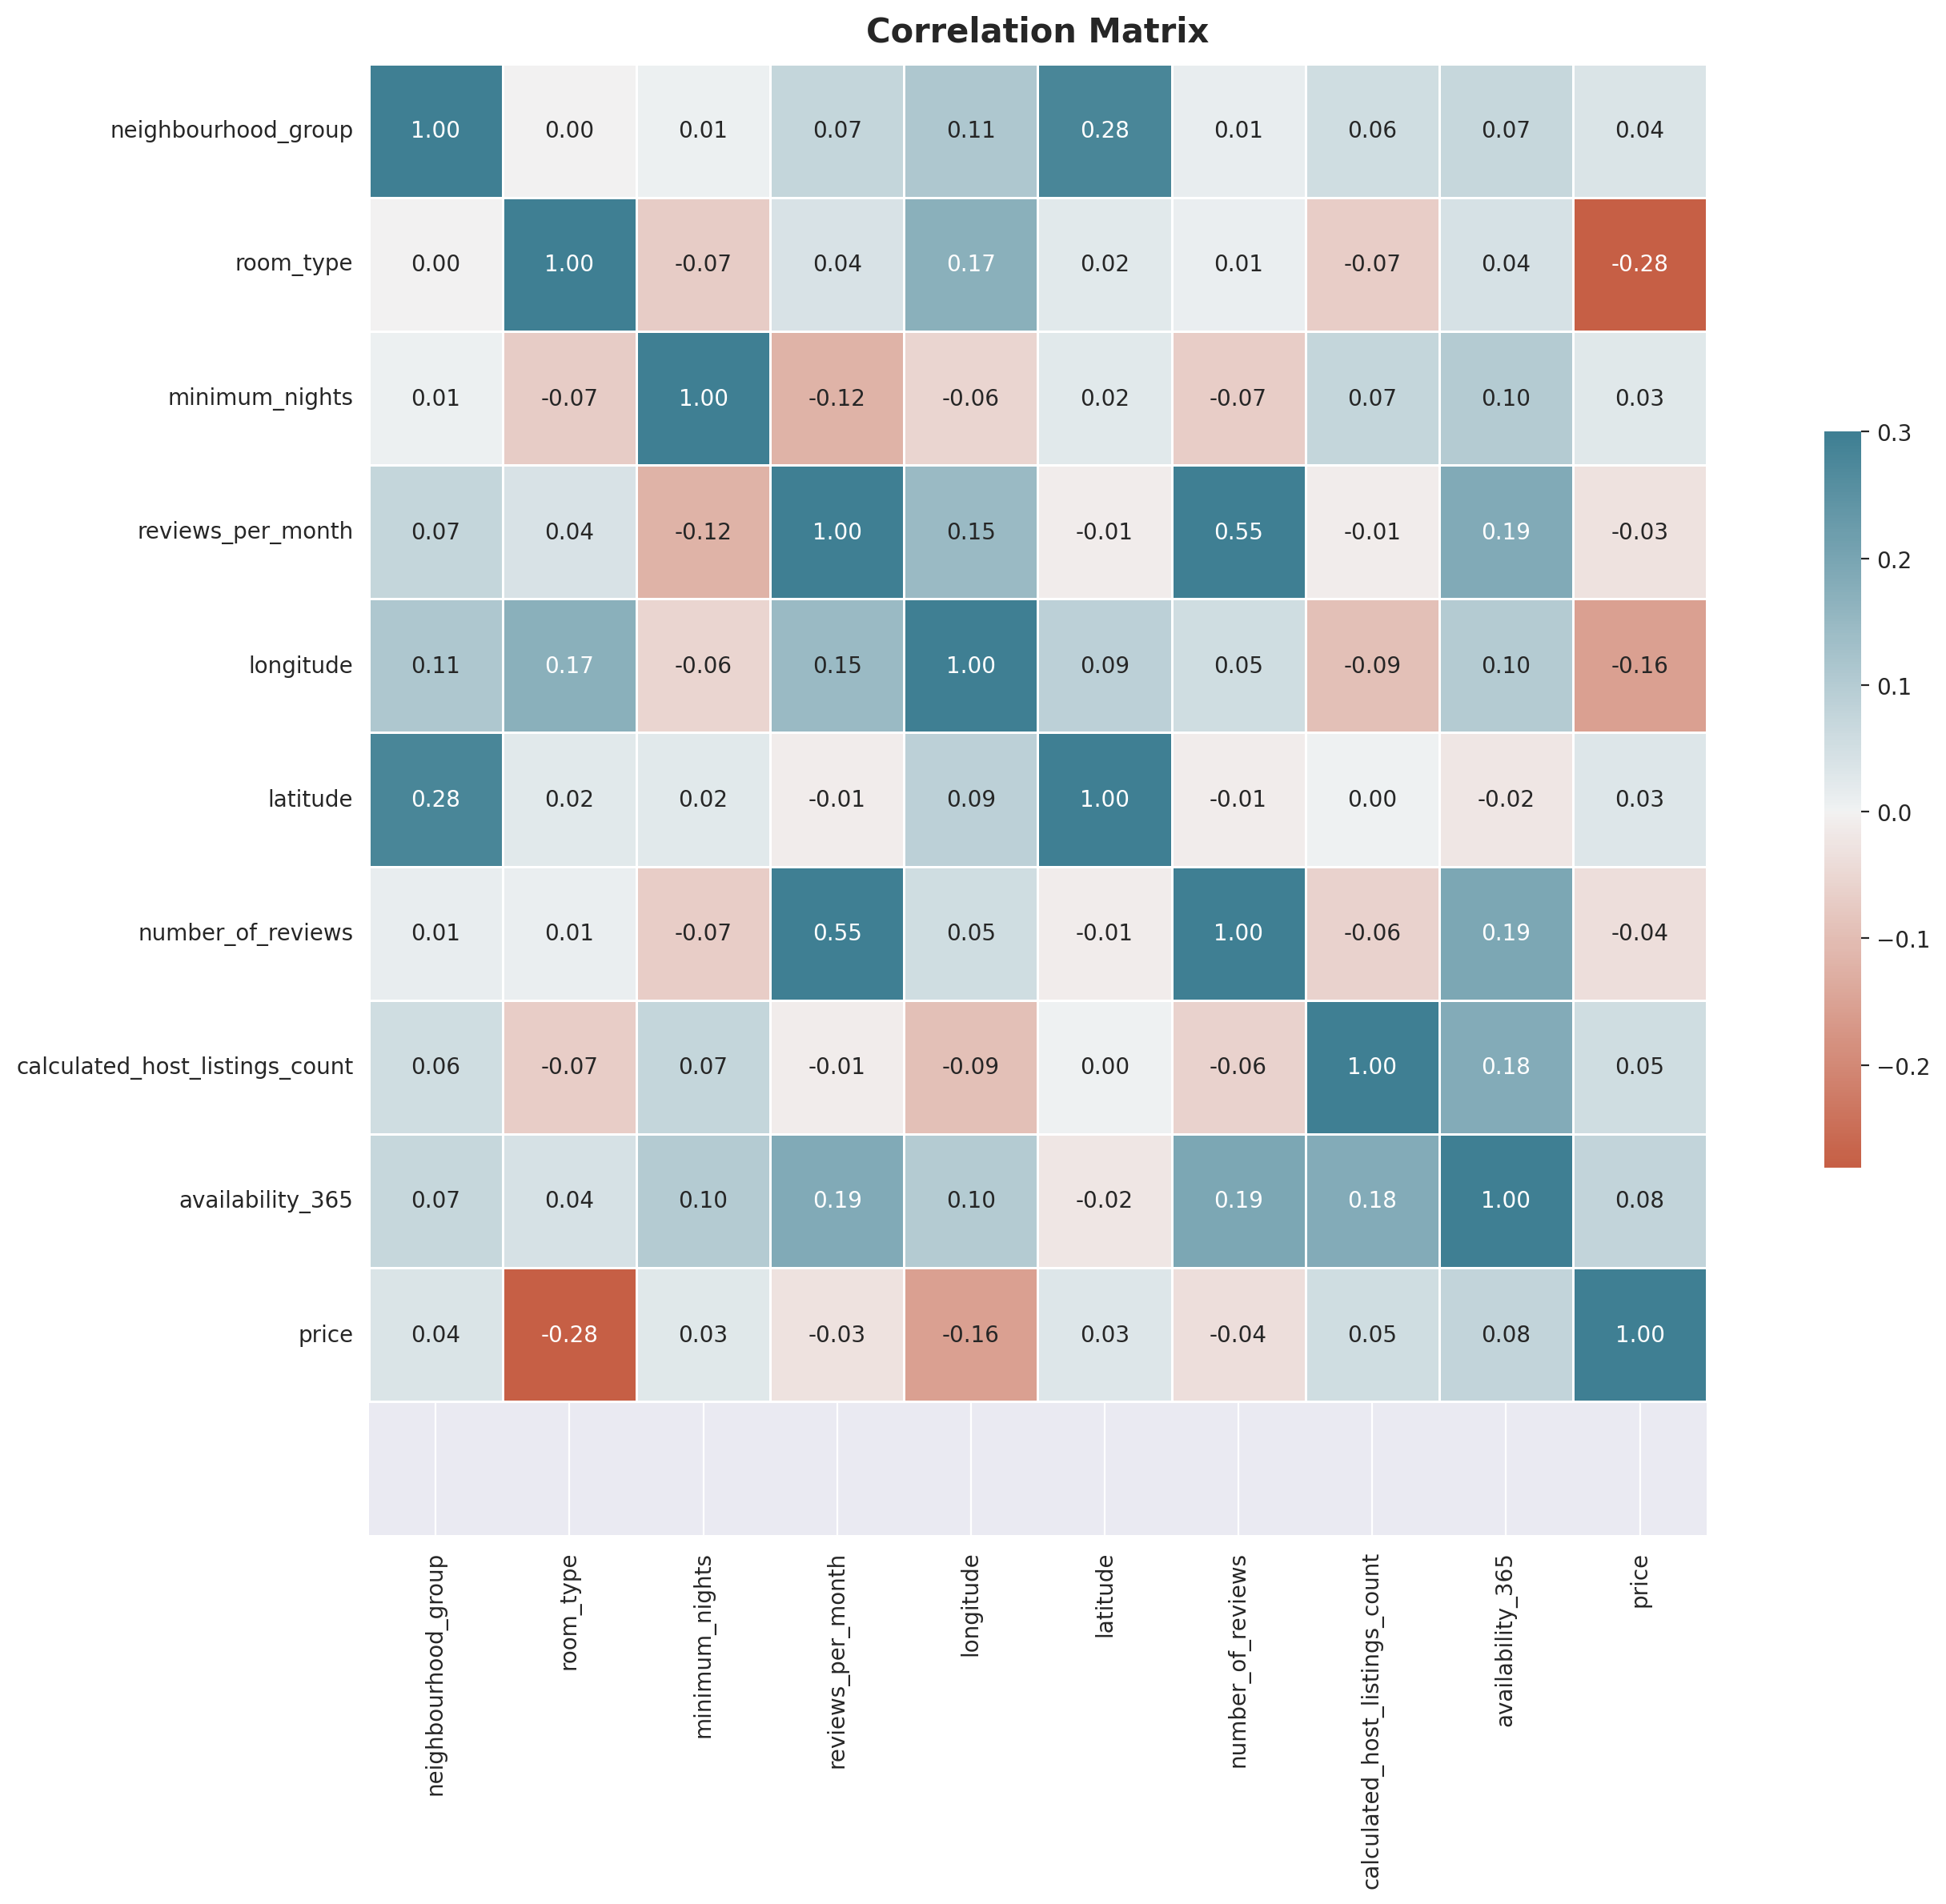

In [43]:
features = [
    "neighbourhood_group",
    "room_type",
    "minimum_nights",
    "reviews_per_month",
    "longitude",
    "latitude",
    "number_of_reviews",
    "calculated_host_listings_count",
    "availability_365",
    "price"
]

X = df[features]

# Label Encode the categorical features
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X["neighbourhood_group"] = label_encoder.fit_transform(X["neighbourhood_group"])
X["room_type"] = label_encoder.fit_transform(X["room_type"])

X

plt.figure(figsize=(15,12))
palette = sns.diverging_palette(20, 220, n=256)
corr=X.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))
plt.title("Correlation Matrix",size=15, weight='bold')

### Model Building with Random Forests and Linear Regression and Neural Networks
---

In [44]:
# Prepare the df for modeling
features = [
    "neighbourhood_group",
    "room_type",
    "minimum_nights",
    "reviews_per_month",
    "longitude",
    "latitude",
    "number_of_reviews",
    "calculated_host_listings_count",
    "availability_365",
]

# 'neighbourhood_group','room_type','price','minimum_nights','calculated_host_listings_count','availability_365'
X = df[features]
y = df["log_price"]

# Label encoding for categorical features
X = pd.get_dummies(X, drop_first=True)

# Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split the df into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model Dictionary
model_dictionary = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
}

# Initialize Evaluation Dictionary
eval_dictionary = {}

# Train and evaluate the models
for model_name, model in model_dictionary.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    eval_dictionary[model_name] = {
        "mae": mean_absolute_error(y_test, y_pred),
        "mse": mean_squared_error(y_test, y_pred),
        "r2": r2_score(y_test, y_pred),
    }

# Store results in a dataframe with models as index and metrics as columns
eval_df = pd.DataFrame(eval_dictionary).T

# eval_df.round(3)

In [46]:
import tensorflow as tf

# Check if TensorFlow can detect the GPU
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("GPUs detected:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPUs detected.")

# Optionally, set memory growth to avoid TensorFlow from allocating all GPU memory
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

GPUs detected:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


Epoch 1/50
195/195 - 5s - 25ms/step - loss: 4.5367 - val_loss: 2.3495
Epoch 2/50
195/195 - 1s - 5ms/step - loss: 1.7543 - val_loss: 0.6543
Epoch 3/50
195/195 - 1s - 5ms/step - loss: 1.4010 - val_loss: 0.4601
Epoch 4/50
195/195 - 1s - 5ms/step - loss: 1.2331 - val_loss: 0.3982
Epoch 5/50
195/195 - 1s - 5ms/step - loss: 1.0473 - val_loss: 0.3383
Epoch 6/50
195/195 - 1s - 4ms/step - loss: 0.9518 - val_loss: 0.3031
Epoch 7/50
195/195 - 1s - 5ms/step - loss: 0.8518 - val_loss: 0.3088
Epoch 8/50
195/195 - 1s - 4ms/step - loss: 0.7928 - val_loss: 0.2709
Epoch 9/50
195/195 - 1s - 4ms/step - loss: 0.7481 - val_loss: 0.2615
Epoch 10/50
195/195 - 1s - 4ms/step - loss: 0.7114 - val_loss: 0.2540
Epoch 11/50
195/195 - 1s - 4ms/step - loss: 0.6783 - val_loss: 0.2417
Epoch 12/50
195/195 - 1s - 4ms/step - loss: 0.6395 - val_loss: 0.2640
Epoch 13/50
195/195 - 1s - 5ms/step - loss: 0.6165 - val_loss: 0.2451
Epoch 14/50
195/195 - 1s - 5ms/step - loss: 0.5799 - val_loss: 0.2321
Epoch 15/50
195/195 - 1s - 5

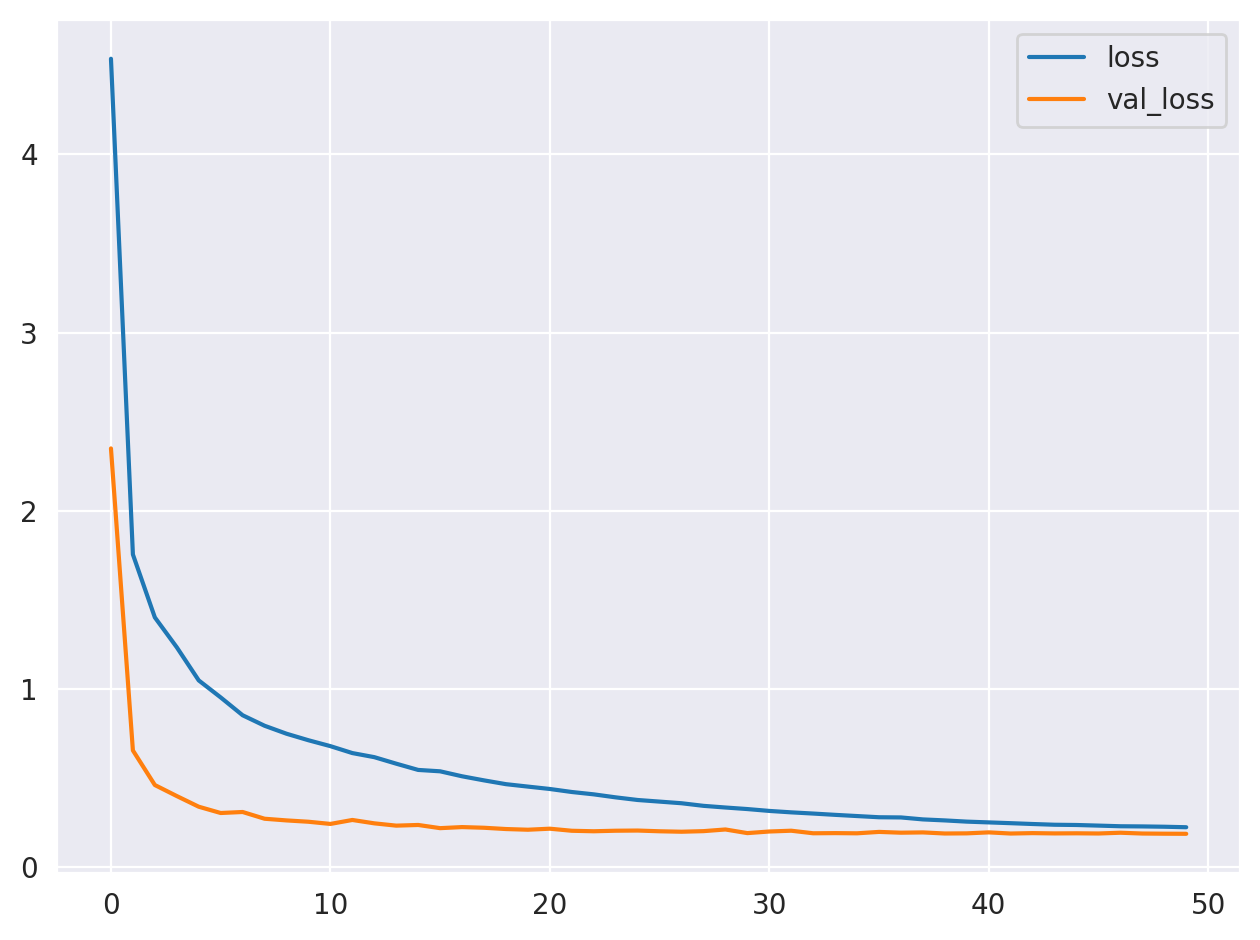

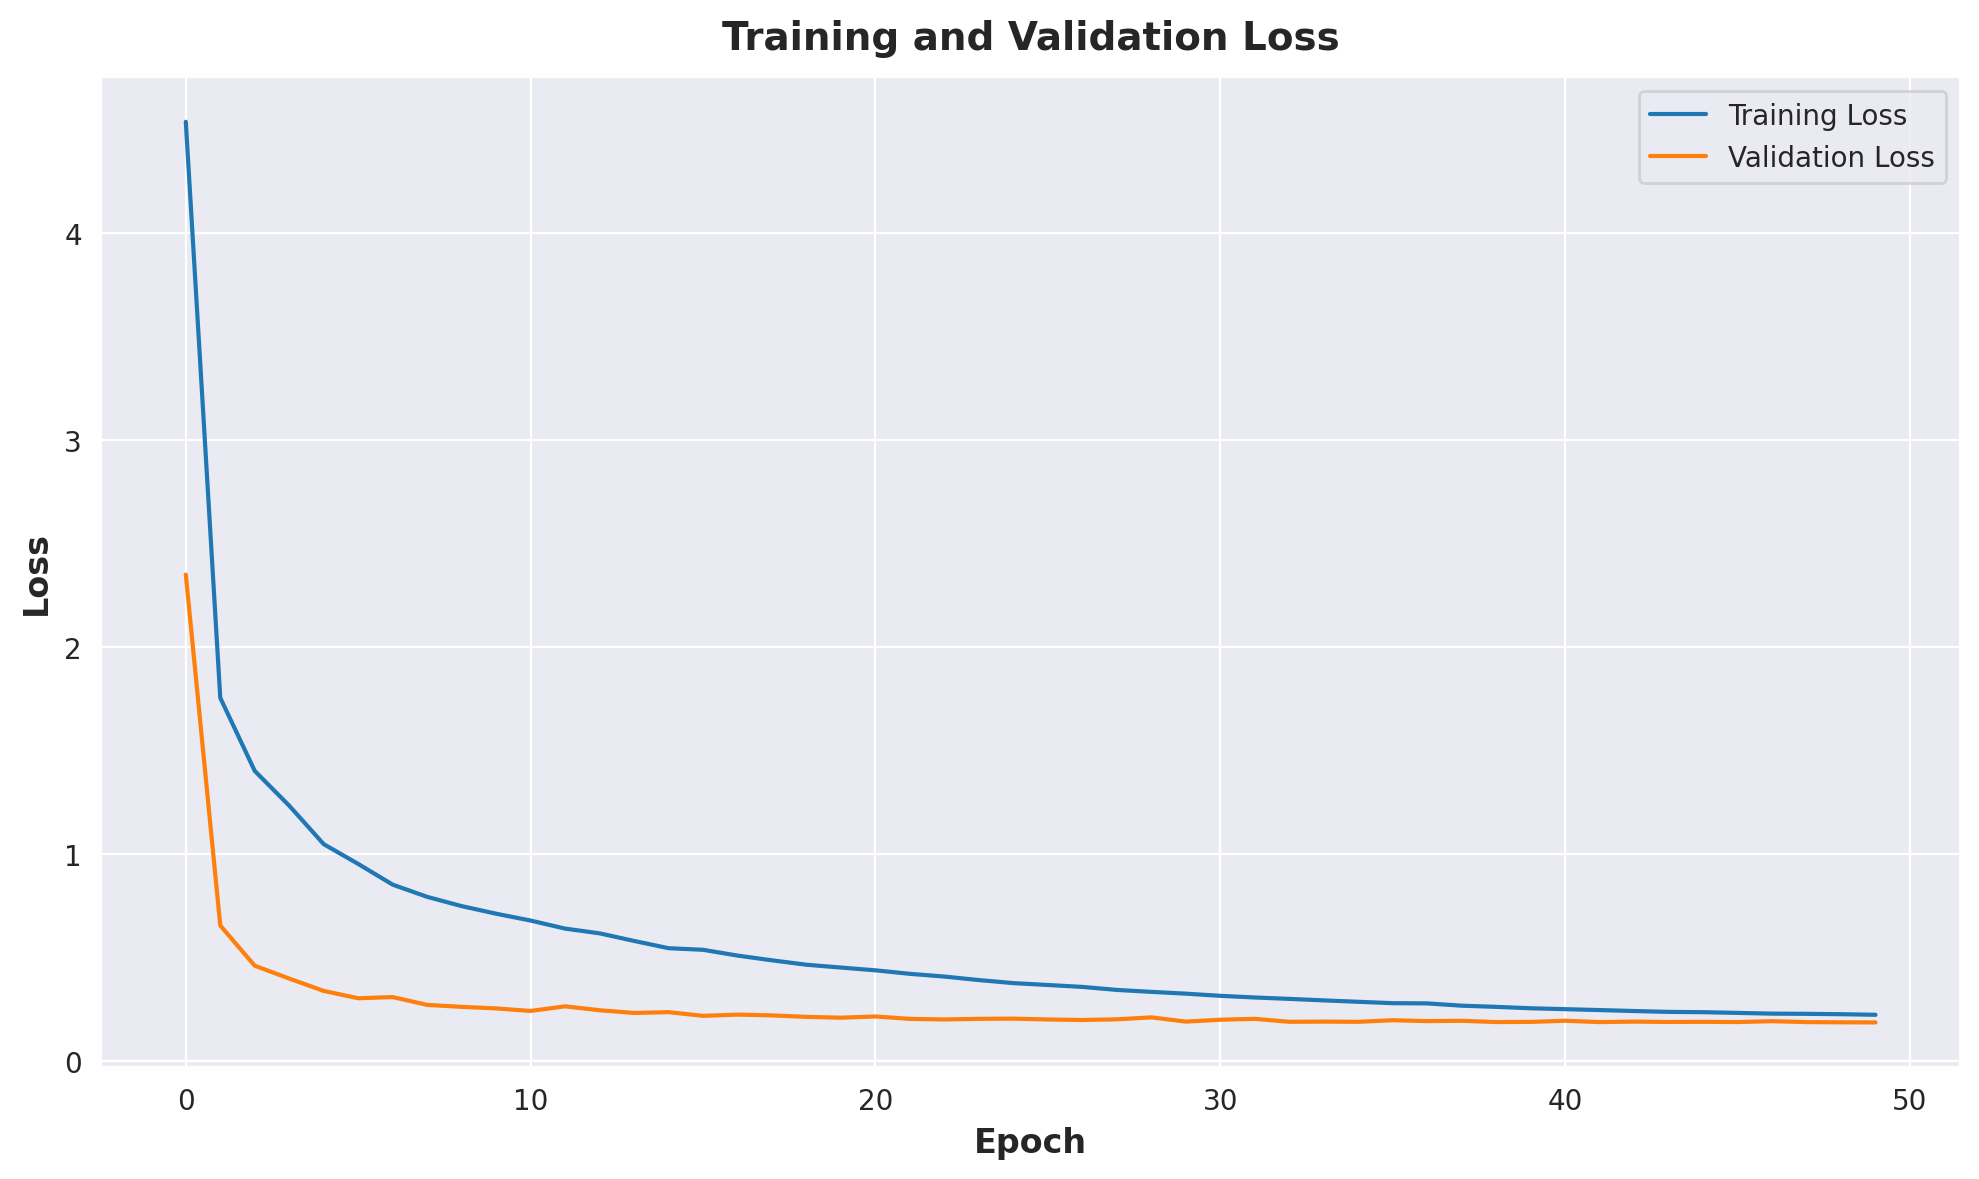

,mae,mse,r2
Linear Regression,0.337211,0.212902,0.524340
Random Forest Regressor,0.299030,0.175673,0.607517
Neural Network,0.311950,0.191297,0.572609


In [47]:
# Build a neural network to predict the price
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

def build_model():
    model = Sequential(
        [
            BatchNormalization(input_shape=(X_train.shape[1],)),
            Dense(64, activation="relu"),
            Dropout(0.3),
            BatchNormalization(),
            Dense(32, activation="relu"),
            Dropout(0.3),
            Dense(1),
        ]
    )
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")
    return model



model = build_model()
history = model.fit(X_train, y_train, epochs=50,batch_size=128, validation_split=0.2, verbose=2)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

y_pred_nn = model.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Add Neural Network results to the evaluation dictionary
eval_dictionary["Neural Network"] = {
    "mae": mae_nn,
    "mse": mse_nn,
    "r2": r2_nn,
}

# Store results in a dataframe with models as index and metrics as columns
eval_df = pd.DataFrame(eval_dictionary).T

eval_df

In [18]:
# Plot random forest feature importances

# Fit the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a DataFrame with feature names and importances
feature_importances = pd.DataFrame(
    {"feature": feature_names, "importance": importances}
)

# Sort the DataFrame in descending order of feature importances
feature_importances = feature_importances.sort_values(by="importance", ascending=False)


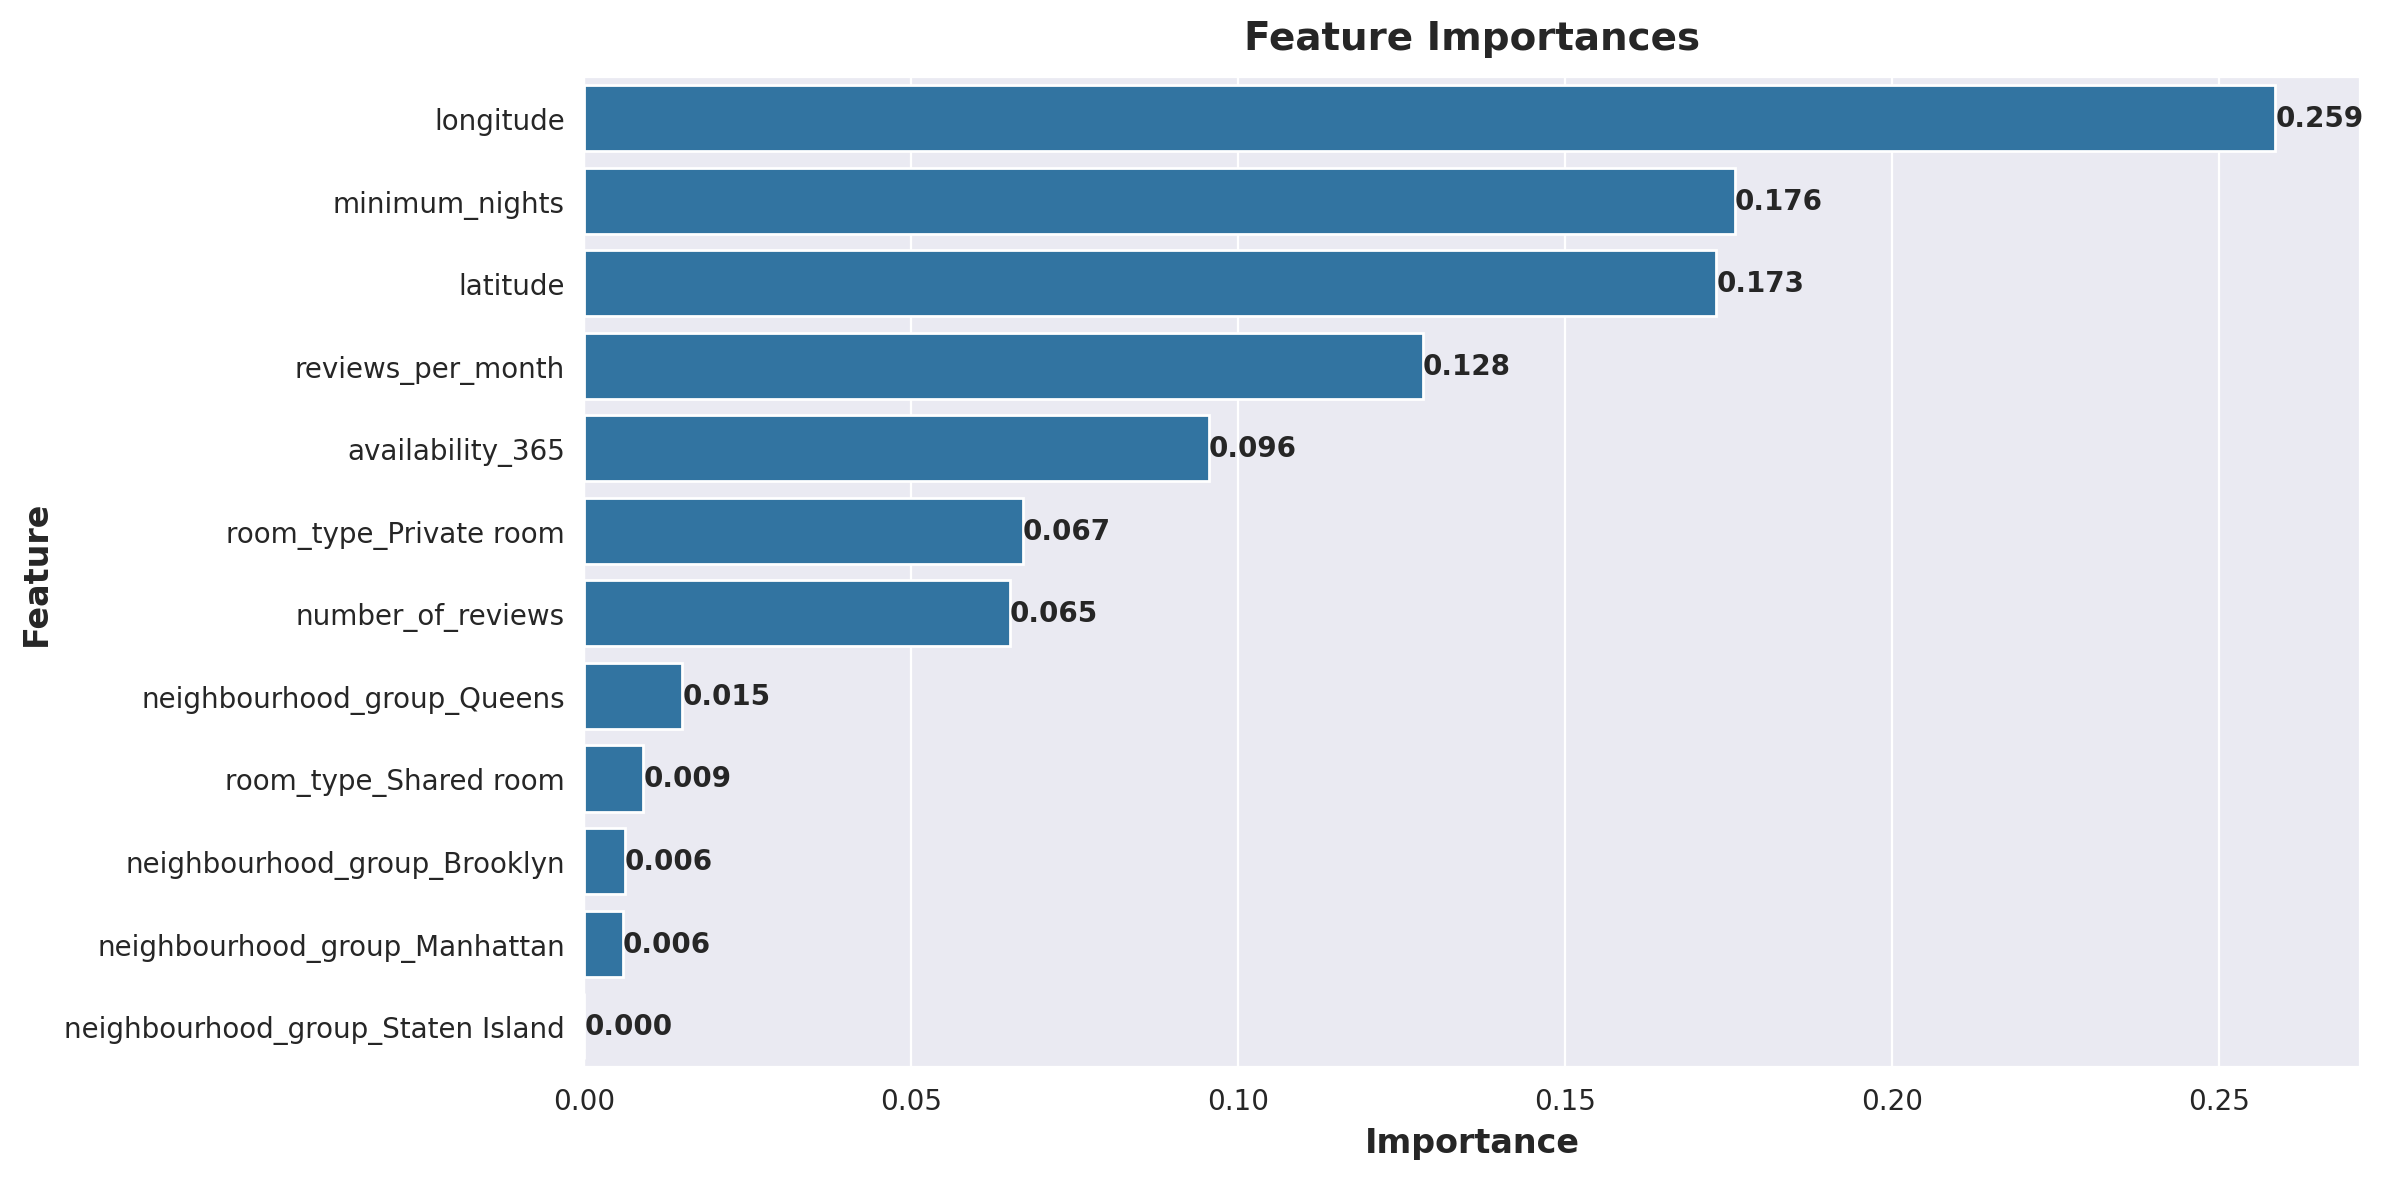

In [19]:
# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 6))
barplot = sns.barplot(data=feature_importances, x="importance", y="feature", ax=ax)

# Iterate over the containers and add bar labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fmt='%.3f', fontsize=10, fontweight='bold')

plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

- Three models were evaluated:
  1. Linear Regression
  2. Random Forest Regressor
  3. Neural Network

- Performance metrics:
  - MAE (Mean Absolute Error)
  - MSE (Mean Squared Error)
  - R2 (Coefficient of Determination)

- Key findings:
  - The Neural Network performed best overall:
    - Lowest MSE (23725.827)
    - Highest R2 (0.175)
    - Lowest MAE (56.812)
  - Linear Regression was a close second:
    - Slightly higher MSE (23961.173)
    - 2nd Highest R2 (0.167)
    - Highest MAE (60.960)
  - Random Forest Regressor underperformed:
    - Highest MSE (25097.922)
    - Lowest R2 (0.128)
    - 2nd Least MAE (57.450)

- Observations:
  - All models have relatively low R2 values, indicating limited predictive power
  - The small differences in performance suggest simple linear models may be sufficient 